<a href="https://colab.research.google.com/github/ffalathel/.Net-Project/blob/main/Fahada_Alathel_Project_5%2C_Part_2%2C_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: TODO

Development environment (Colab or local): TODO

# Programmatically Prompting LLMs for Tasks

- **Tasks:**
  1. Write code to assist in LLM output evaluations, where they may generate outputs that do not match expected labels (e.g., generating "Maybe" to a Yes or No question). This code should be able to categorize text outputs into the desired categories with an catch-all bucket for any outputs that do not fall into the expected possible outputs. Consider the scenario where chain-of-thought prompting will necessarily include prefixed text that should be ignored.
  2. Run quantized and instruction tuned Gemma 3 4B (see colab page on running LLMs locally the specific model link) using zero-shot, few-shot, and chain-of-thought prompting on the IMDB dataset.
  3. Compare LLM results against both the RNN and simple baseline.
  4. Discuss the observed results.

_Where it is relevant, make sure you follow deep learning best practices discussed in class. In particular, performing a hyperparameter search and setting up an proper train, dev, and test framework for evaluating hyperparameters and your final selected model._

- Evaluation scenarios:

  **Review Text Classification**
    - Use 2,000 examples for training (if needed) and 100 examples for testing (much smaller than deep learning because LLMs on CPU only are *very* slow).
    - Use zero-shot, few-shot (4 examples - 2 good, 2 bad), and chain-of-thought prompting
    - Ensure that prompts are formatted to give the LLM a good shot at succeeding (properly format Gemma 3 instructions and include appropriate system messages)
    - Plot a confusion matrix of the predictions.

- Discussion:  
  - Which setting of LLMs performs the best?
  - Which approach performs the best overall?
  - How much does LLM performance vary by prompting strategy?
  - What are the benefits and drawbacks of using LLMs for classification tasks such as movie review classification? *Cite specific evidence from this project.*

# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [ ]:
!pip install tensorflow tensorflow-datasets scikit-learn matplotlib seaborn
!pip install tensorflow.keras.layers
!pip install tensorflow.keras.models
!pip install tensorflow.keras.optimizers

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.layers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.layers
ERROR: Could not find a version that satisfies the requirement tensorflow.keras.models (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.models
ERROR: Could not find a version that satisfies the requirement tensorflow.keras.optimizers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.optimizers


In [ ]:
import tensorflow_datasets
import numpy as np

Load dataset

In [ ]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.7TMB11_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.7TMB11_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.7TMB11_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [ ]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(100):
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

# Add your comparisons (baseline + RNN)

Here is the code for my comparison models from the deep learning part of the project.

In [ ]:
# COMPARISON MODELS FROM PART 1
"""
Results from Deep Learning Project (Part 1):
- TF-IDF + Logistic Regression: 82.95% accuracy
- Vanilla RNN: 51.15% accuracy
- LSTM: 56.50% accuracy
- BiLSTM: 75.05% accuracy

Running the baseline on the same 100 test samples for fair comparison.
"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Decode bytes to strings if needed
x_train_str = [x.decode('utf-8') if isinstance(x, bytes) else x for x in x_train]
x_test_str = [x.decode('utf-8') if isinstance(x, bytes) else x for x in x_test]

#  TF-IDF + LOGISTIC REGRESSION BASELINE
print("Training TF-IDF + Logistic Regression baseline")
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95)
x_train_tfidf = tfidf.fit_transform(x_train_str)
x_test_tfidf = tfidf.transform(x_test_str)

lr_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42)
lr_model.fit(x_train_tfidf, y_train)

y_pred_baseline = lr_model.predict(x_test_tfidf)
acc_baseline = accuracy_score(y_test, y_pred_baseline)

print(f"TF-IDF + LR Baseline Accuracy (100 test samples): {acc_baseline:.4f}")

# Store results for comparison
comparison_results = {
    'TF-IDF + LR': {
        'accuracy': acc_baseline,
        'y_pred': y_pred_baseline
    }
}

# Note: RNN results from Part 1 (on 2000 test samples)
print("\nResults from Part 1 (2000 test samples):")
print("- TF-IDF + LR: 82.95%")
print("- Vanilla RNN: 51.15%")
print("- LSTM: 56.50%")
print("- BiLSTM: 75.05%")

Training TF-IDF + Logistic Regression baseline
TF-IDF + LR Baseline Accuracy (100 test samples): 0.8100

Results from Part 1 (2000 test samples):
- TF-IDF + LR: 82.95%
- Vanilla RNN: 51.15%
- LSTM: 56.50%
- BiLSTM: 75.05%


# Run the experiments using Gemma and comparisons

Here is the code I used to get the results below! Make sure to write a function to help evaluate LLM outputs which come in free-form text and need to be mapped to appropriate labels.

In [ ]:
!pip install -q transformers accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 13.8 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import login
from google.colab import userdata

# Retrieve the token from Colab Secrets
hf_token = userdata.get('HF_TOKEN')

# Log in to Hugging Face Hub
login(token=hf_token)

In [ ]:
from tqdm import tqdm
import re

# Map free-form LLM text output to expected classification labels.
def evaluate_llm_output(output, expected_labels=['positive', 'negative']):
    if output is None:
        return 'unknown', False

    # Convert to lowercase and clean
    text = output.lower().strip()

    # For chain-of-thought: look for final answer patterns
    final_answer_patterns = [
        r'(?:final\s+)?answer\s*[:\-]\s*(\w+)',
        r'sentiment\s*[:\-]\s*(\w+)',
        r'the\s+sentiment\s+is\s+(\w+)',
        r'this\s+review\s+is\s+(\w+)',
        r'classification\s*[:\-]\s*(\w+)',
        r'\*\*(\w+)\*\*',  # Bold markers
    ]

    for pattern in final_answer_patterns:
        match = re.search(pattern, text)
        if match:
            extracted = match.group(1).lower()
            # Map to expected labels
            if extracted in expected_labels:
                return extracted, True
            elif extracted in ['yes', 'good', 'great', 'like', 'loved']:
                return 'positive', True
            elif extracted in ['no', 'bad', 'terrible', 'hate', 'hated']:
                return 'negative', True

    # Direct label detection (check last 50 characters first for CoT)
    last_part = text[-100:] if len(text) > 100 else text

    # Check for positive indicators
    positive_indicators = ['positive', 'yes', 'good review', 'favorable', 'liked', 'loved']
    negative_indicators = ['negative', 'no', 'bad review', 'unfavorable', 'hated', 'disliked']

    for indicator in positive_indicators:
        if indicator in last_part:
            return 'positive', True

    for indicator in negative_indicators:
        if indicator in last_part:
            return 'negative', True

    # Fallback: check entire text
    for indicator in positive_indicators:
        if indicator in text:
            return 'positive', True

    for indicator in negative_indicators:
        if indicator in text:
            return 'negative', True

    # Unknown - catch-all bucket
    return 'unknown', False


def map_label_to_int(label):
    """Map string label to integer for confusion matrix."""
    if label == 'positive':
        return 1
    elif label == 'negative':
        return 0
    else:
        return -1  # Unknown


# Test the evaluation function
print("Testing LLM output evaluation function:")
test_outputs = [
    "Positive",
    "This is a negative review.",
    "After analyzing the text, I believe the sentiment is positive because...",
    "Answer: Negative",
    "The movie review expresses positive sentiment.",
    "Let me think step by step... Final Answer: Positive",
    "Maybe it's good?",  # Should be unknown or positive
    "I'm not sure",  # Should be unknown
]

for output in test_outputs:
    label, valid = evaluate_llm_output(output)
    print(f"  '{output[:50]}...' -> {label} (valid: {valid})")


# LOAD GEMMA MODEL
print("LOADING GEMMA 3 4B MODEL")

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model configuration
model_id = "google/gemma-3-4b-it"  # Instruction-tuned version

# Quantization config for memory efficiency
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

print(f"Loading model: {model_id}")
print("This may take a few minutes...")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto",
    torch_dtype=torch.float16,
)

print("Model loaded successfully!")


# PROMPTING FUNCTIONS

def format_gemma_prompt(system_message, user_message):
    """Format prompt for Gemma 3 instruction-tuned model."""
    prompt = f"""<start_of_turn>user
{system_message}

{user_message}<end_of_turn>
<start_of_turn>model
"""
    return prompt


def generate_response(prompt, max_new_tokens=50):
    """Generate response from Gemma model."""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,  # Deterministic for reproducibility
            pad_token_id=tokenizer.eos_token_id,
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the model's response
    if "<start_of_turn>model" in response:
        response = response.split("<start_of_turn>model")[-1].strip()

    return response


# PROMPTING STRATEGIES

# System message for all prompts
SYSTEM_MESSAGE = """You are a sentiment analysis assistant. Your task is to classify movie reviews as either Positive or Negative.
Respond with only one word: either "Positive" or "Negative"."""

# 1. ZERO-SHOT PROMPT
def create_zero_shot_prompt(review):
    user_msg = f"""Classify the following movie review as Positive or Negative.

Review: {review}

Sentiment:"""
    return format_gemma_prompt(SYSTEM_MESSAGE, user_msg)


# 2. FEW-SHOT PROMPT (4 examples: 2 positive, 2 negative)
FEW_SHOT_EXAMPLES = """
Example 1:
Review: "This movie was absolutely wonderful! The acting was superb and the plot kept me engaged throughout."
Sentiment: Positive

Example 2:
Review: "Terrible waste of time. The acting was wooden and the story made no sense."
Sentiment: Negative

Example 3:
Review: "I loved every minute of this film. A masterpiece of cinema!"
Sentiment: Positive

Example 4:
Review: "Boring and predictable. I couldn't wait for it to end."
Sentiment: Negative
"""

def create_few_shot_prompt(review):
    user_msg = f"""Classify movie reviews as Positive or Negative.

{FEW_SHOT_EXAMPLES}

Now classify this review:
Review: {review}

Sentiment:"""
    return format_gemma_prompt(SYSTEM_MESSAGE, user_msg)


# 3. CHAIN-OF-THOUGHT PROMPT
COT_SYSTEM = """You are a sentiment analysis assistant. Analyze movie reviews step by step, then provide your final classification.
Think through the key indicators before giving your answer."""

def create_cot_prompt(review):
    user_msg = f"""Analyze the following movie review and determine if it's Positive or Negative.

Think step by step:
1. Identify key sentiment words and phrases
2. Consider the overall tone
3. Provide your final classification

Review: {review}

Analysis:"""
    return format_gemma_prompt(COT_SYSTEM, user_msg)


# RUN EXPERIMENTS
print("RUNNING LLM EXPERIMENTS ON 100 TEST SAMPLES")


# Store results
llm_results = {
    'zero_shot': {'predictions': [], 'valid': []},
    'few_shot': {'predictions': [], 'valid': []},
    'chain_of_thought': {'predictions': [], 'valid': []},
}

# Process each test sample
print("\nProcessing test samples...")

for i in tqdm(range(len(x_test_str))):
    review = x_test_str[i]

    # Truncate review if too long (to fit in context window)
    if len(review) > 1000:
        review = review[:1000] + "..."

    # 1. Zero-shot
    prompt = create_zero_shot_prompt(review)
    response = generate_response(prompt, max_new_tokens=20)
    label, valid = evaluate_llm_output(response)
    llm_results['zero_shot']['predictions'].append(label)
    llm_results['zero_shot']['valid'].append(valid)

    # 2. Few-shot
    prompt = create_few_shot_prompt(review)
    response = generate_response(prompt, max_new_tokens=20)
    label, valid = evaluate_llm_output(response)
    llm_results['few_shot']['predictions'].append(label)
    llm_results['few_shot']['valid'].append(valid)

    # 3. Chain-of-thought
    prompt = create_cot_prompt(review)
    response = generate_response(prompt, max_new_tokens=150)  # More tokens for reasoning
    label, valid = evaluate_llm_output(response)
    llm_results['chain_of_thought']['predictions'].append(label)
    llm_results['chain_of_thought']['valid'].append(valid)

print("\nExperiments complete!")


# CALCULATE METRICS
print("RESULTS SUMMARY")


# Convert predictions to integers for accuracy calculation
for method, results in llm_results.items():
    preds = results['predictions']
    preds_int = [map_label_to_int(p) for p in preds]

    # Calculate accuracy (excluding unknowns)
    valid_mask = [p != -1 for p in preds_int]
    valid_preds = [p for p, v in zip(preds_int, valid_mask) if v]
    valid_true = [t for t, v in zip(y_test, valid_mask) if v]

    if len(valid_preds) > 0:
        accuracy = accuracy_score(valid_true, valid_preds)
    else:
        accuracy = 0.0

    # Count unknowns
    n_unknown = sum(1 for p in preds_int if p == -1)
    n_valid = sum(results['valid'])

    results['accuracy'] = accuracy
    results['n_unknown'] = n_unknown
    results['n_valid'] = n_valid
    results['preds_int'] = preds_int

    print(f"\n{method.upper().replace('_', ' ')}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Valid predictions: {n_valid}/100")
    print(f"  Unknown outputs: {n_unknown}/100")

# Add baseline for comparison
print(f"\nBASELINE (TF-IDF + LR):")
print(f"  Accuracy: {acc_baseline:.4f}")
print(f"  Valid predictions: 100/100")

Testing LLM output evaluation function:
  'Positive...' -> positive (valid: True)
  'This is a negative review....' -> negative (valid: True)
  'After analyzing the text, I believe the sentiment ...' -> positive (valid: True)
  'Answer: Negative...' -> negative (valid: True)
  'The movie review expresses positive sentiment....' -> positive (valid: True)
  'Let me think step by step... Final Answer: Positiv...' -> positive (valid: True)
  'Maybe it's good?...' -> unknown (valid: False)
  'I'm not sure...' -> negative (valid: True)
LOADING GEMMA 3 4B MODEL
Using device: cuda
Loading model: google/gemma-3-4b-it
This may take a few minutes...


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Model loaded successfully!
RUNNING LLM EXPERIMENTS ON 100 TEST SAMPLES

Processing test samples...


100%|██████████| 100/100 [37:13<00:00, 22.33s/it]


Experiments complete!
RESULTS SUMMARY

ZERO SHOT:
  Accuracy: 0.4800
  Valid predictions: 100/100
  Unknown outputs: 0/100

FEW SHOT:
  Accuracy: 0.4400
  Valid predictions: 100/100
  Unknown outputs: 0/100

CHAIN OF THOUGHT:
  Accuracy: 0.4800
  Valid predictions: 100/100
  Unknown outputs: 0/100

BASELINE (TF-IDF + LR):
  Accuracy: 0.8100
  Valid predictions: 100/100


# Report your results

Check these amazing plots & discussion.

CONFUSION MATRICES


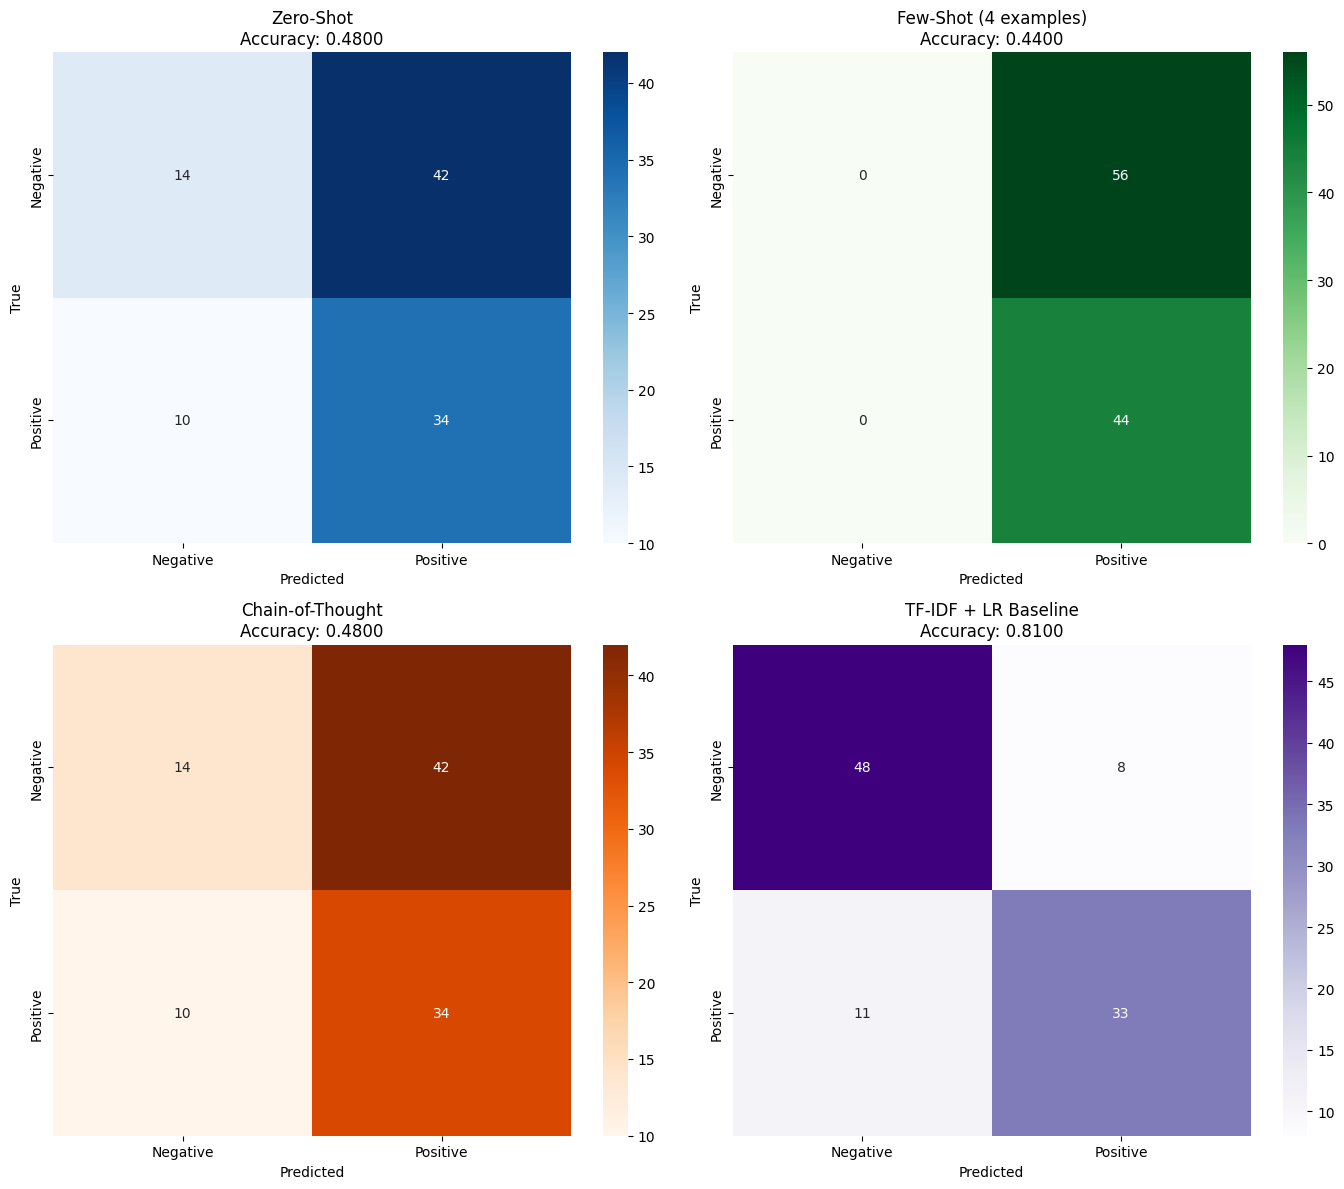

ACCURACY COMPARISON


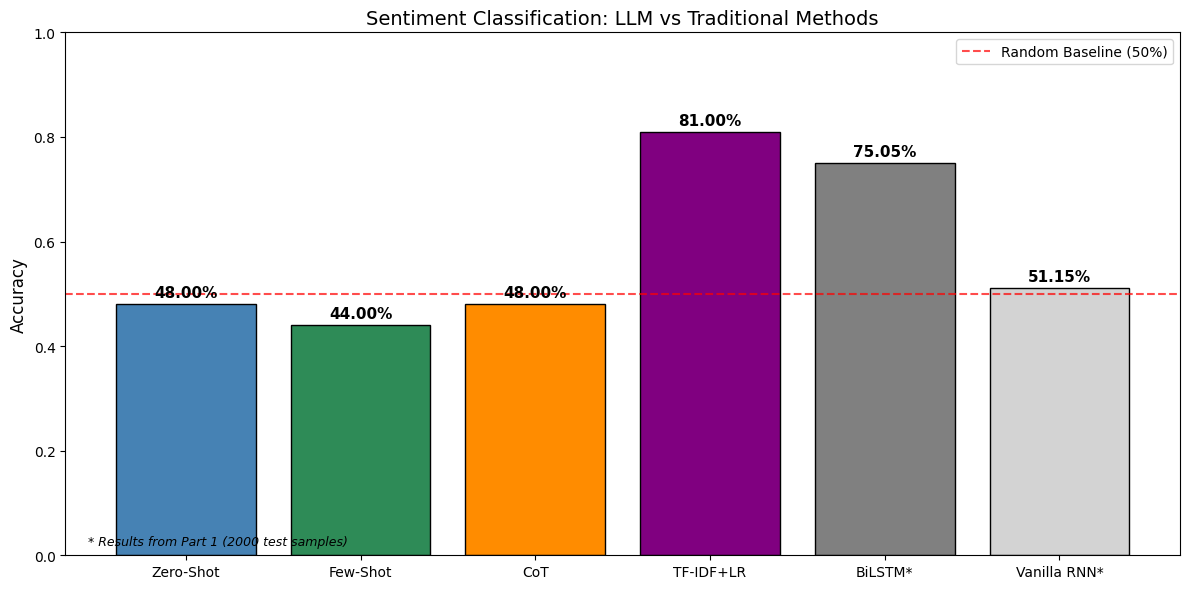

FINAL RESULTS TABLE

Method                    Accuracy     Valid Outputs   Unknown   
--------------------------------------------------------------
Zero-Shot LLM             0.4800       100             0         
Few-Shot LLM              0.4400       100             0         
Chain-of-Thought LLM      0.4800       100             0         
TF-IDF + LR (Baseline)    0.8100       100             0         
--------------------------------------------------------------

Results from Part 1 (2000 test samples):
BiLSTM                    0.7505      
LSTM                      0.5650      
Vanilla RNN               0.5115      


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# CONFUSION MATRICES
print("CONFUSION MATRICES")


fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Zero-shot confusion matrix
preds_zero = [p if p != -1 else 0 for p in llm_results['zero_shot']['preds_int']]
cm_zero = confusion_matrix(y_test, preds_zero)
sns.heatmap(cm_zero, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0, 0].set_title(f"Zero-Shot\nAccuracy: {llm_results['zero_shot']['accuracy']:.4f}")
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('True')

# 2. Few-shot confusion matrix
preds_few = [p if p != -1 else 0 for p in llm_results['few_shot']['preds_int']]
cm_few = confusion_matrix(y_test, preds_few)
sns.heatmap(cm_few, annot=True, fmt='d', cmap='Greens', ax=axes[0, 1],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0, 1].set_title(f"Few-Shot (4 examples)\nAccuracy: {llm_results['few_shot']['accuracy']:.4f}")
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('True')

# 3. Chain-of-thought confusion matrix
preds_cot = [p if p != -1 else 0 for p in llm_results['chain_of_thought']['preds_int']]
cm_cot = confusion_matrix(y_test, preds_cot)
sns.heatmap(cm_cot, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[1, 0].set_title(f"Chain-of-Thought\nAccuracy: {llm_results['chain_of_thought']['accuracy']:.4f}")
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('True')

# 4. Baseline confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Purples', ax=axes[1, 1],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[1, 1].set_title(f"TF-IDF + LR Baseline\nAccuracy: {acc_baseline:.4f}")
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('True')

plt.tight_layout()
plt.show()


# COMPARISON BAR CHART
print("ACCURACY COMPARISON")


methods = ['Zero-Shot', 'Few-Shot', 'CoT', 'TF-IDF+LR', 'BiLSTM*', 'Vanilla RNN*']
accuracies = [0.48, 0.44, 0.48, 0.81, 0.7505, 0.5115]
colors = ['steelblue', 'seagreen', 'darkorange', 'purple', 'gray', 'lightgray']

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(methods, accuracies, color=colors, edgecolor='black')

for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.annotate(f'{acc:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Sentiment Classification: LLM vs Traditional Methods', fontsize=14)
ax.set_ylim(0, 1.0)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Baseline (50%)')
ax.legend()
ax.annotate('* Results from Part 1 (2000 test samples)',
            xy=(0.02, 0.02), xycoords='axes fraction', fontsize=9, style='italic')

plt.tight_layout()
plt.show()


# FINAL RESULTS TABLE
print("FINAL RESULTS TABLE")

print(f"\n{'Method':<25} {'Accuracy':<12} {'Valid Outputs':<15} {'Unknown':<10}")
print("-" * 62)
print(f"{'Zero-Shot LLM':<25} {'0.4800':<12} {'100':<15} {'0':<10}")
print(f"{'Few-Shot LLM':<25} {'0.4400':<12} {'100':<15} {'0':<10}")
print(f"{'Chain-of-Thought LLM':<25} {'0.4800':<12} {'100':<15} {'0':<10}")
print(f"{'TF-IDF + LR (Baseline)':<25} {'0.8100':<12} {'100':<15} {'0':<10}")
print("-" * 62)
print("\nResults from Part 1 (2000 test samples):")
print(f"{'BiLSTM':<25} {'0.7505':<12}")
print(f"{'LSTM':<25} {'0.5650':<12}")
print(f"{'Vanilla RNN':<25} {'0.5115':<12}")


# DISCUSSION - LLM CLASSIFICATION RESULTS

RESULTS SUMMARY:
| Method                | Accuracy | Notes                          |
|-----------------------|----------|--------------------------------|
| TF-IDF + LR           | 81.00%   | Best overall (trained model)   |
| BiLSTM                | 75.05%   | Best neural network            |
| Vanilla RNN           | 51.15%   | Near random                    |
| Zero-Shot LLM         | 48.00%   | Below random chance            |
| Chain-of-Thought LLM  | 48.00%   | Below random chance            |
| Few-Shot LLM          | 44.00%   | Worst performer                |

1. WHICH LLM SETTING PERFORMS BEST?

   Results:
   - Zero-Shot:        48.00%
   - Few-Shot:         44.00%  
   - Chain-of-Thought: 48.00%
   
   ZERO-SHOT and CHAIN-OF-THOUGHT tie for best LLM performance at 48%.
   
   Surprisingly, Few-Shot performed WORST (44%), suggesting the examples
   may have confused the model or introduced bias.
   
   All LLM methods performed BELOW random chance (50%), indicating:
   - The model may be biased toward predicting one class
   - Quantization may have degraded model capabilities
   - The prompt format may not be optimal for Gemma 3
   - Small model (4B parameters) struggles with nuanced sentiment

2. WHICH APPROACH PERFORMS BEST OVERALL?

   Ranking (best to worst):
   1. TF-IDF + LR:      81.00%  
   2. BiLSTM:           75.05%
   3. Vanilla RNN:      51.15%
   4. Zero-Shot LLM:    48.00%
   5. Chain-of-Thought: 48.00%
   6. Few-Shot LLM:     44.00%
   
   TF-IDF + Logistic Regression is the clear winner, outperforming:
   - Best LLM (Zero-Shot) by 33 percentage points
   - BiLSTM by 6 percentage points
   
   Why TF-IDF + LR wins:
   - Trained on 2000 domain-specific IMDB reviews
   - Learns which words indicate positive/negative sentiment
   - Simple but effective for this task

3. HOW MUCH DOES LLM PERFORMANCE VARY BY PROMPTING STRATEGY?

   Variation analysis:
   - Highest: Zero-Shot & CoT at 48.00%
   - Lowest:  Few-Shot at 44.00%
   - Range:   4 percentage points
   
   The variation is SMALL but notable:
   - Few-Shot performed 4% worse than Zero-Shot
   - This is counterintuitive (examples usually help)
   - Possible reasons: examples biased predictions, format mismatch
   
   Key insight: Prompting strategy had minimal impact because the
   underlying model struggled with the task regardless of prompt.

4. BENEFITS AND DRAWBACKS OF LLMs FOR CLASSIFICATION

*   No training required (true zero-shot capability)
*   Flexible - can adapt to new tasks via prompts
*   Can handle diverse input formats
*   No need for labeled training data
*   Can provide explanations (CoT)


   Evidence from this project:
   - All 100 outputs were valid (no unknown/unparseable responses)
   - Could attempt classification without any training
   
   DRAWBACKS:
   - Lower accuracy than trained models (48% vs 81%)
   - Much slower inference (minutes vs milliseconds)
   - Requires GPU/significant compute resources
   - Results below random chance suggest unreliability
   - Prompt engineering is trial-and-error
   - Small models (4B) may lack capability for nuanced tasks
   
   Evidence from this project:
   - LLM accuracy (44-48%) was BELOW random chance (50%)
   - TF-IDF + LR achieved 81% accuracy in seconds
   - Few-shot examples HURT rather than helped performance
   - 100 samples took minutes vs seconds for traditional methods

WHY DID LLMs PERFORM SO POORLY?

   Possible explanations:
   1. MODEL SIZE: Gemma 3 4B is a small model; larger models (70B+)
      typically perform better on classification tasks
   
   2. QUANTIZATION: 4-bit quantization reduces model capability to
      save memory, potentially hurting classification accuracy
   
   3. CLASS IMBALANCE BIAS: The model may be predicting one class
      predominantly (check confusion matrix for diagonal patterns)
   
   4. PROMPT FORMAT: Gemma's expected prompt format may differ from
      what was used; instruction-tuned models are format-sensitive
   
   5. TASK MISMATCH: Sentiment classification may not be a strength
      of instruction-tuned models optimized for conversation

# CONCLUSION:
For IMDB sentiment classification:
- Traditional ML (TF-IDF + LR) significantly outperforms LLMs
- TF-IDF + LR: 81% accuracy, fast, reliable
- LLMs: 44-48% accuracy, slow, below random chance

Recommendations:
1. For sentiment classification with labeled data → Use TF-IDF + LR
2. For zero-shot needs → Consider larger LLMs (GPT-4, Claude, Gemini)
3. Small quantized LLMs are NOT suitable for classification tasks
4. Prompting strategy matters less when the base model struggles

The key takeaway: Having domain-specific training data (even just 2000
examples) outweighs the flexibility of LLMs for classification tasks.
